In [63]:
# Komórka 1: Import niezbędnych bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf # Dla formuł w regresji
from sklearn.model_selection import train_test_split
# Możemy potrzebować innych modeli, ale zacznijmy od LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Ustawienia dla lepszej wizualizacji
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
%matplotlib inline

In [64]:
# Komórka 2: Wczytanie danych
# UWAGA: Musisz podać prawidłową ścieżkę lub URL do pliku CSV z nowymi kolumnami.
# Poniższy URL to placeholder. Zastąp go właściwym.
# Jeśli plik jest lokalny, użyj pd.read_csv("nazwa_pliku.csv")

# PRZYKŁADOWE TWORZENIE DANYCH, JEŚLI NIE MASZ PLIKU - ZASTĄP PRAWDZIWYM WCZYTANIEM
# To jest tylko symulacja, aby kod mógł działać. Użyj swoich danych!
data = pd.read_csv("publishers.csv",header=0,
                   names=['genre','sold_by','daily_rev','daily_auth_rev','daily_avg_gross_sales',
                          'daily_avg_pub_rev','daily_avd_uni_sold','pub_name','pub_type',
                          'avg_rating','price','sales_rank','reviews'])
df = pd.DataFrame(data)

# Upewnij się, że kolumny mają właściwe nazwy (np. literówki)
df.rename(columns={'daily_avd_uni_sold': 'daily_avg_uni_sold'}, inplace=True, errors='ignore') # Poprawka nazwy

# Wyświetlenie informacji o danych
print("Pierwsze 5 wierszy danych:")
print(df.head())
print("\nInformacje o typach danych i brakujących wartościach:")
df.info()
print("\nPodstawowe statystyki dla kolumn numerycznych:")
print(df.describe(include=np.number))
print("\nPodstawowe statystyki dla kolumn kategorycznych:")
print(df.describe(include='object'))
print(f"\nLiczba unikalnych wydawców: {df['pub_name'].nunique()}")
print(f"\nLiczba unikalnych gatunków: {df['genre'].nunique()}")
print(f"Całkowita liczba wierszy: {len(df)}")

Pierwsze 5 wierszy danych:
           genre                         sold_by  daily_rev  daily_auth_rev  \
0  genre fiction        HarperCollins Publishers     6832.0          6832.0   
1  genre fiction        HarperCollins Publishers     2487.5          2487.5   
2  genre fiction  Amazon Digital Services,  Inc.     9559.0          9559.0   
3        fiction             Hachette Book Group     8250.0          8250.0   
4  genre fiction         Penguin Group (USA) LLC     7590.5          7590.5   

   daily_avg_gross_sales  daily_avg_pub_rev  daily_avg_uni_sold  \
0                34160.0            20496.0                7000   
1                12437.5             7462.5                6250   
2                47795.0            28677.0                5500   
3                41250.0            24750.0                5500   
4                37952.5            22771.5                4750   

                      pub_name      pub_type  avg_rating  price  sales_rank  \
0        Katheri

In [65]:
# Komórka 3: Sprawdzenie i obsługa brakujących danych
print("\nLiczba brakujących wartości w każdej kolumnie:")
print(df.isnull().sum())

# Strategie dla brakujących danych:
# Kategoryczne: 'genre', 'sold_by', 'pub_type' - można wypełnić modą lub "Unknown"
for col in ['genre', 'sold_by', 'pub_type']:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Wypełniono NaN w '{col}' modą: {mode_val}")

# Numeryczne: np. 'avg_rating', 'price', 'reviews' - można wypełnić medianą
numerical_cols_to_fill = ['daily_rev', 'daily_auth_rev', 'daily_avg_gross_sales',
                          'daily_avg_pub_rev', 'daily_avg_uni_sold', 'avg_rating',
                          'price', 'sales_rank', 'reviews']
for col in numerical_cols_to_fill:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Wypełniono NaN w '{col}' medianą: {median_val}")

print("\nLiczba brakujących wartości po czyszczeniu:")
print(df.isnull().sum())

# Sprawdzenie duplikatów
print(f"\nLiczba zduplikowanych wierszy: {df.duplicated().sum()}")
# df.drop_duplicates(inplace=True) # Jeśli są i chcemy je usunąć


Liczba brakujących wartości w każdej kolumnie:
genre                    0
sold_by                  0
daily_rev                0
daily_auth_rev           0
daily_avg_gross_sales    0
daily_avg_pub_rev        0
daily_avg_uni_sold       0
pub_name                 0
pub_type                 0
avg_rating               0
price                    0
sales_rank               0
reviews                  0
dtype: int64

Liczba brakujących wartości po czyszczeniu:
genre                    0
sold_by                  0
daily_rev                0
daily_auth_rev           0
daily_avg_gross_sales    0
daily_avg_pub_rev        0
daily_avg_uni_sold       0
pub_name                 0
pub_type                 0
avg_rating               0
price                    0
sales_rank               0
reviews                  0
dtype: int64

Liczba zduplikowanych wierszy: 0


In [66]:
# Komórka 4: Tworzenie nowych cech

# Udział przychodu wydawcy w sprzedaży brutto
df['pub_rev_share'] = (df['daily_avg_pub_rev'] / df['daily_avg_gross_sales']).fillna(0)
df.loc[df['daily_avg_gross_sales'] == 0, 'pub_rev_share'] = 0 # Unikanie dzielenia przez zero

# Udział przychodu autora w sprzedaży brutto
df['auth_rev_share'] = (df['daily_auth_rev'] / df['daily_avg_gross_sales']).fillna(0)
df.loc[df['daily_avg_gross_sales'] == 0, 'auth_rev_share'] = 0

# Przychód na jednostkę (powinno być zbliżone do ceny, ale może uwzględniać rabaty/koszty)
df['revenue_per_unit'] = (df['daily_avg_gross_sales'] / df['daily_avg_uni_sold']).fillna(0)
df.loc[df['daily_avg_uni_sold'] == 0, 'revenue_per_unit'] = 0

# Recenzje na 1000 sprzedanych jednostek (jako wskaźnik zaangażowania/popularności)
# Można dostosować mianownik, np. jeśli sprzedaż jest niska
df['reviews_per_1k_sold'] = (df['reviews'] / (df['daily_avg_uni_sold'] / 1000)).fillna(0)
df.loc[df['daily_avg_uni_sold'] == 0, 'reviews_per_1k_sold'] = 0


# Transformacje logarytmiczne dla zmiennych skośnych (bardzo ważne dla sprzedaży, rankingu, recenzji)
# np.log1p(x) to log(x+1), bezpieczne dla wartości zerowych
skewed_cols = ['daily_rev', 'daily_auth_rev', 'daily_avg_gross_sales',
               'daily_avg_pub_rev', 'daily_avg_uni_sold',
               'price', 'sales_rank', 'reviews']
for col in skewed_cols:
    if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
        df[f'log_{col}'] = np.log1p(df[col])
        # Dla sales_rank, niższy jest lepszy. Czasem używa się -log(rank) lub 1/rank,
        # ale log(rank) też jest użyteczne, pamiętając o interpretacji.

print("\nPierwsze 5 wierszy z nowymi i przetransformowanymi cechami (wybrane):")
print(df[['pub_name', 'price', 'log_price', 'sales_rank', 'log_sales_rank', 'pub_rev_share', 'revenue_per_unit']].head())


Pierwsze 5 wierszy z nowymi i przetransformowanymi cechami (wybrane):
                      pub_name  price  log_price  sales_rank  log_sales_rank  \
0        Katherine Tegen Books   4.88   1.771557           1        0.693147   
1        HarperCollins e-books   1.99   1.095273           2        1.098612   
2  (Small or Medium Publisher)   8.69   2.271094           3        1.386294   
3    Little, Brown and Company   7.50   2.140066           3        1.386294   
4            Dutton Children's   7.99   2.196113           4        1.609438   

   pub_rev_share  revenue_per_unit  
0            0.6              4.88  
1            0.6              1.99  
2            0.6              8.69  
3            0.6              7.50  
4            0.6              7.99  


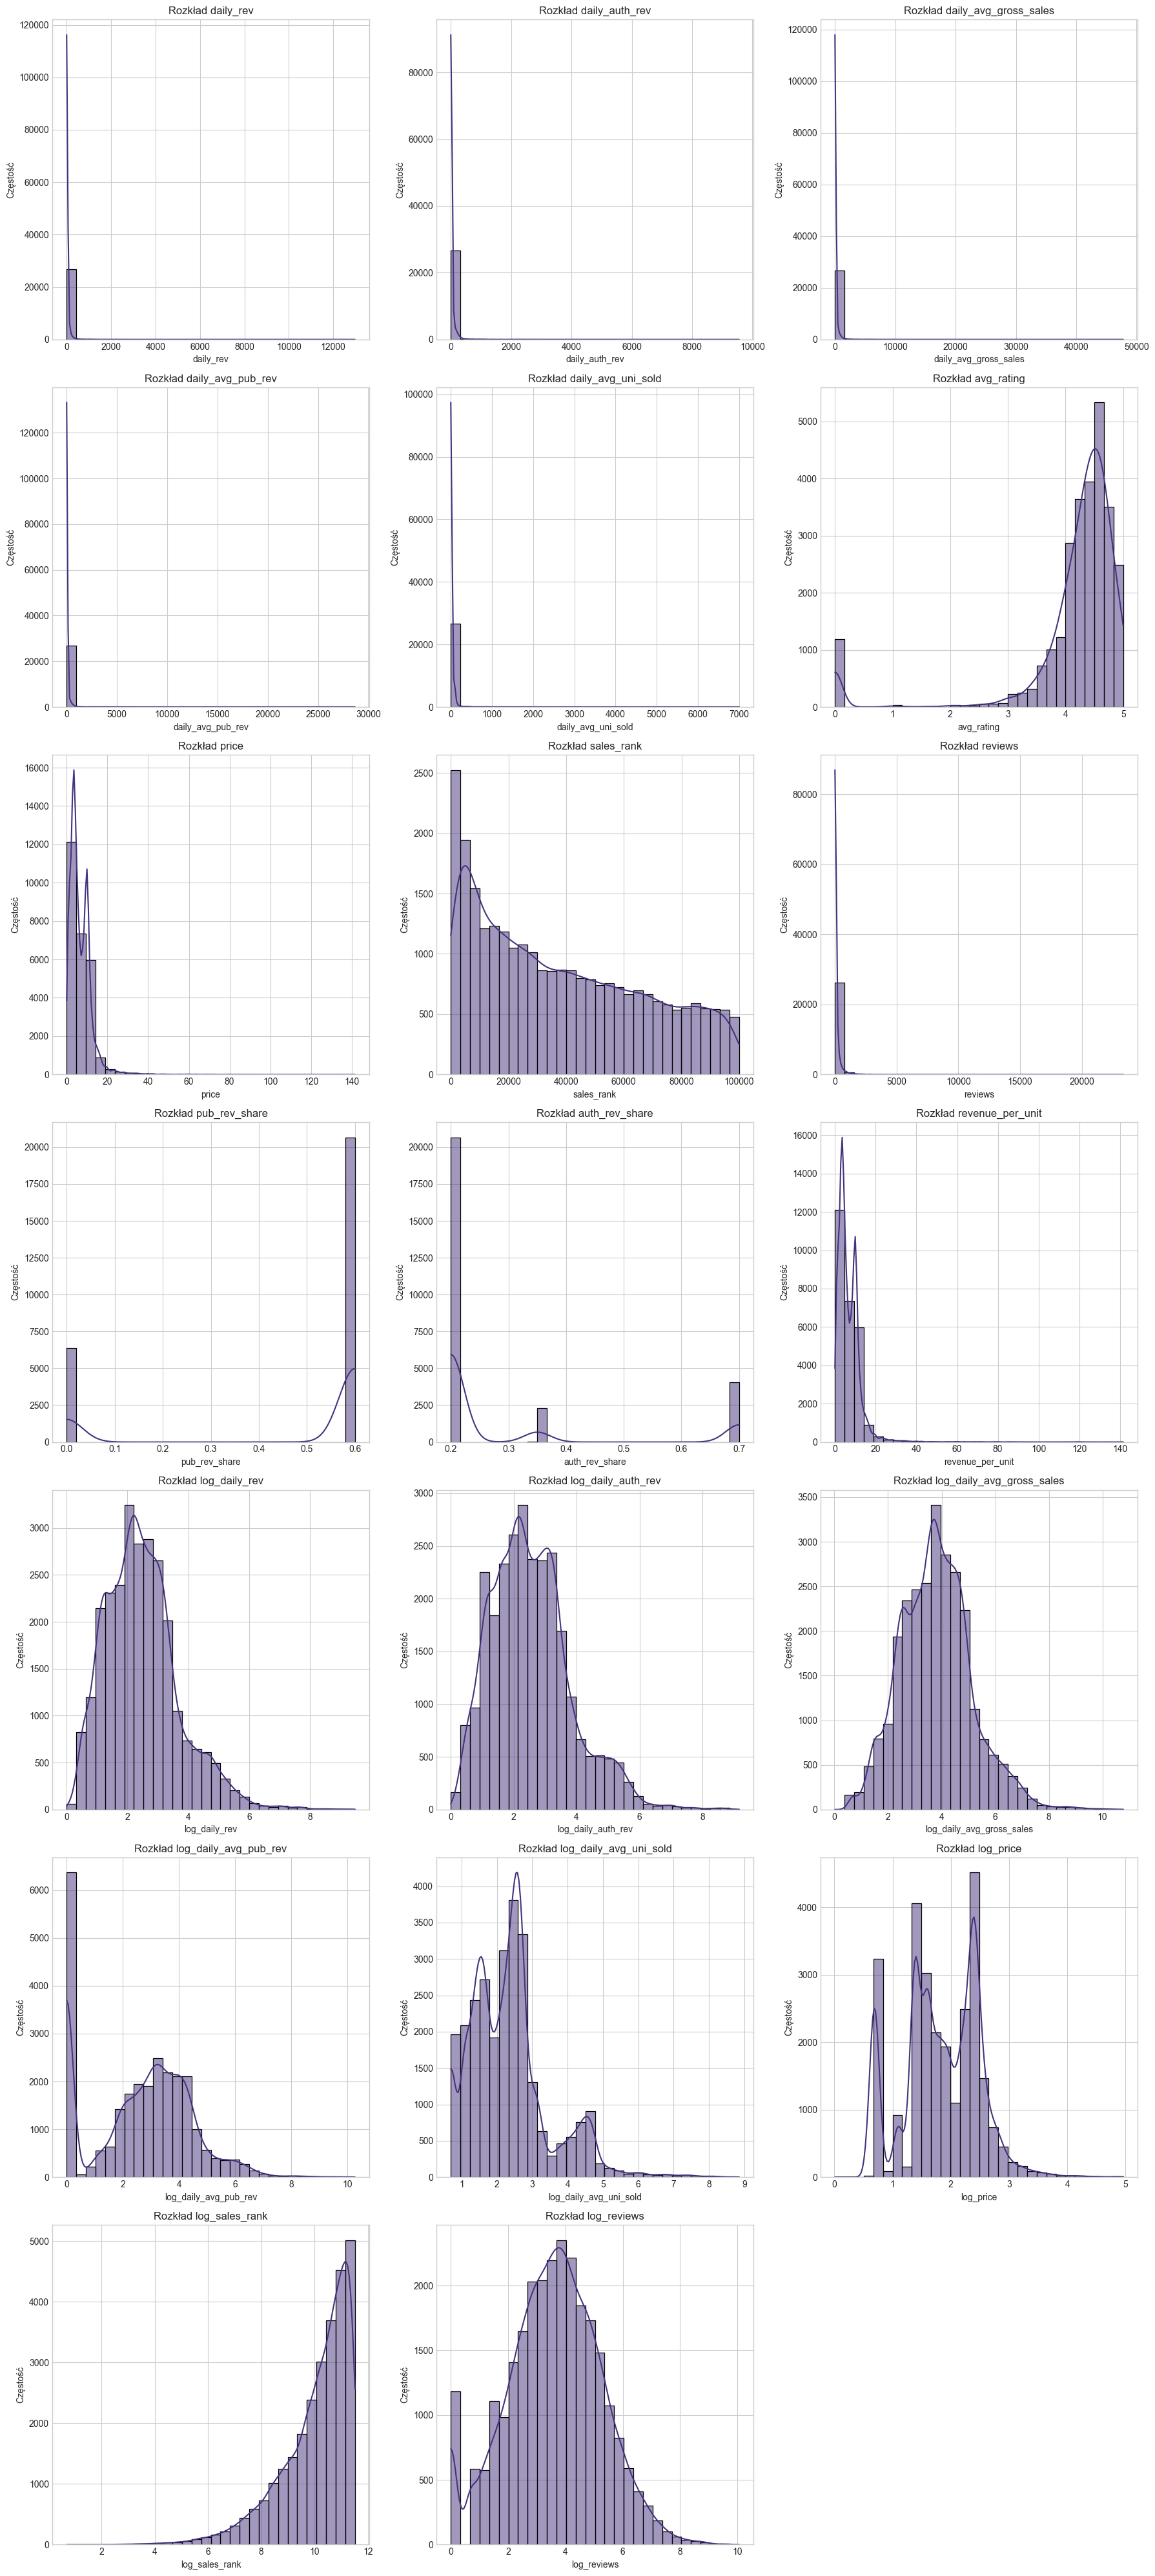

In [67]:
# Komórka 5: Wizualizacje rozkładów zmiennych numerycznych (oryginalnych i zlogarytmowanych)
numerical_cols = ['daily_rev', 'daily_auth_rev', 'daily_avg_gross_sales',
                  'daily_avg_pub_rev', 'daily_avg_uni_sold', 'avg_rating',
                  'price', 'sales_rank', 'reviews',
                  'pub_rev_share', 'auth_rev_share', 'revenue_per_unit']

# Dodajmy też zlogarytmowane wersje do listy, jeśli istnieją
log_numerical_cols = [f'log_{col}' for col in skewed_cols if f'log_{col}' in df.columns]
cols_to_plot_hist = numerical_cols + log_numerical_cols

plt.figure(figsize=(18, len(cols_to_plot_hist) * 2)) # Dynamiczna wysokość
for i, col in enumerate(cols_to_plot_hist):
    if col in df.columns: # Upewnij się, że kolumna istnieje
        plt.subplot( (len(cols_to_plot_hist) + 2) // 3 , 3, i + 1) # Dynamiczny układ subplotów
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Rozkład {col}')
        plt.xlabel(col)
        plt.ylabel('Częstość')
plt.tight_layout()
plt.show()

C:\Users\Cezar\AppData\Local\Temp\ipykernel_23716\4171675737.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=order, palette="viridis")
C:\Users\Cezar\AppData\Local\Temp\ipykernel_23716\4171675737.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=order, palette="viridis")
C:\Users\Cezar\AppData\Local\Temp\ipykernel_23716\4171675737.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=order, palette="viridis")
C:\Users\Cezar\AppData\Local\Temp\ipykernel_23716\4171675737.py:17: Fu

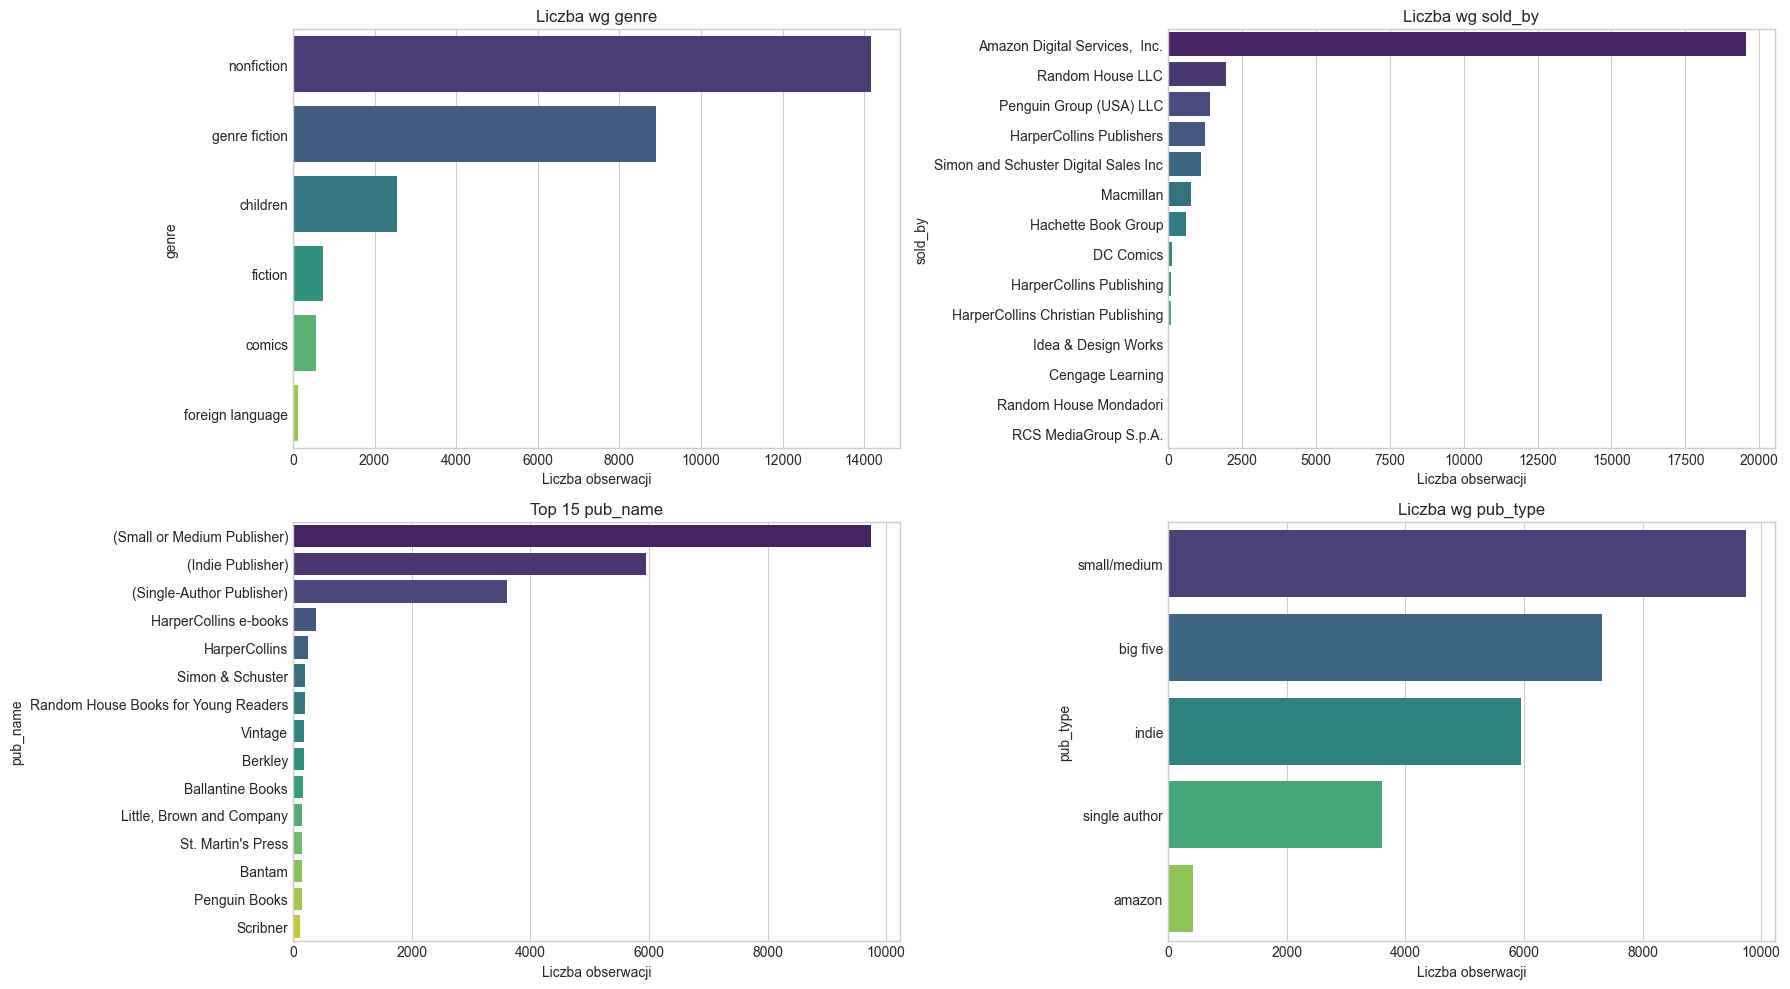

In [68]:
# Komórka 6: Wizualizacje dla zmiennych kategorycznych
categorical_cols = ['genre', 'sold_by', 'pub_name', 'pub_type']

plt.figure(figsize=(18, 10)) # Zwiększona wysokość dla czytelności
subplot_idx = 1
for col in categorical_cols:
    plt.subplot(2, 2, subplot_idx)
    top_n = 15 if col == 'pub_name' or col == 'genre' else df[col].nunique() # Więcej dla pub_name/genre
    
    # Dla kolumn z wieloma unikalnymi wartościami, pokaż top N
    if df[col].nunique() > top_n:
        order = df[col].value_counts().iloc[:top_n].index
        sns.countplot(y=df[col], order=order, palette="viridis")
        plt.title(f'Top {top_n} {col}')
    else:
        order = df[col].value_counts().index
        sns.countplot(y=df[col], order=order, palette="viridis")
        plt.title(f'Liczba wg {col}')
    plt.xlabel('Liczba obserwacji')
    plt.ylabel(col)
    subplot_idx += 1
plt.tight_layout()
plt.show()

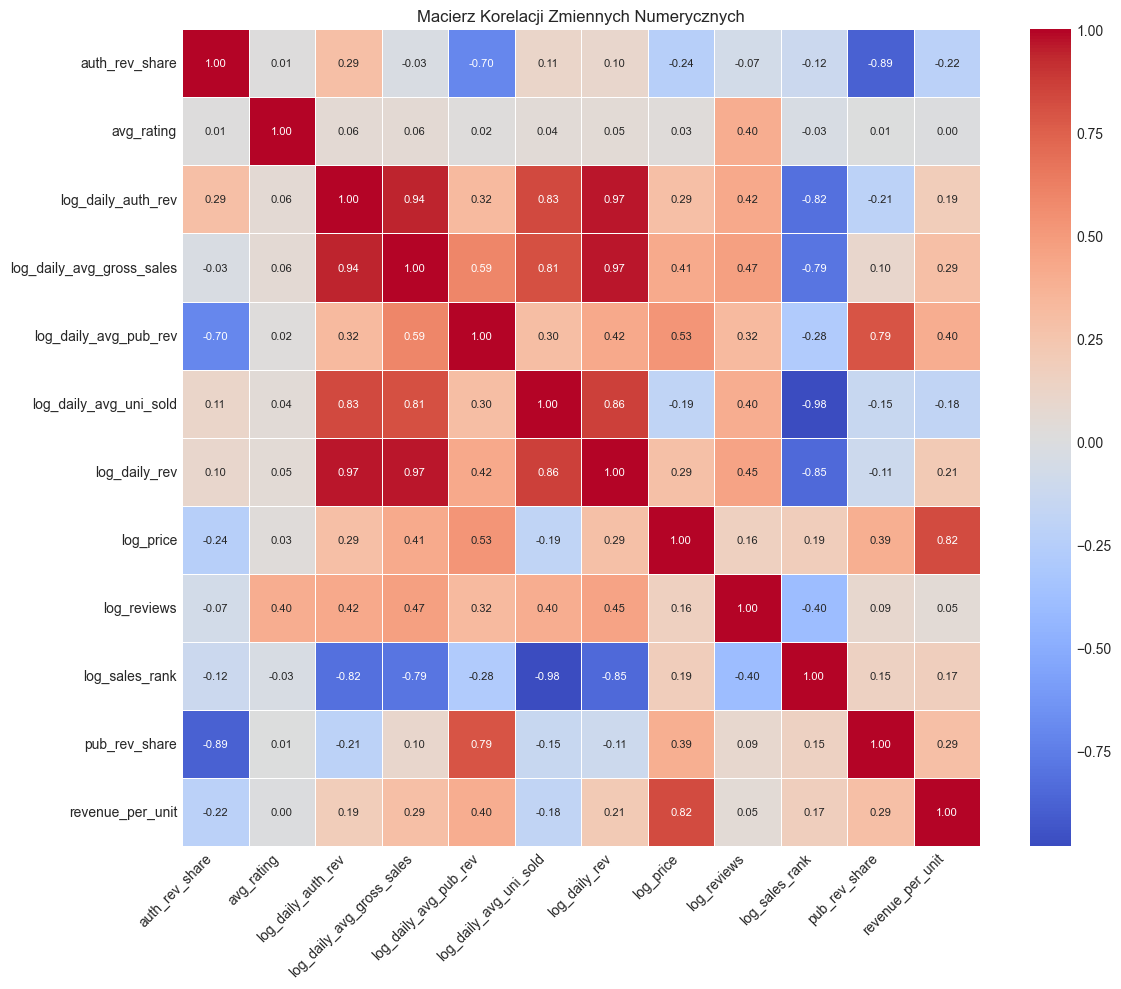

In [69]:
# Komórka 7: Macierz korelacji dla zmiennych numerycznych (lepiej użyć zlogarytmowanych tam, gdzie to możliwe)
cols_for_corr = ['avg_rating', 'pub_rev_share', 'auth_rev_share', 'revenue_per_unit']
for col in skewed_cols: # Dodajemy zlogarytmowane wersje
    if f'log_{col}' in df.columns:
        cols_for_corr.append(f'log_{col}')
    else: # Jeśli nie ma log, użyj oryginalnej (np. jeśli nie była skośna)
        cols_for_corr.append(col)

# Usuń duplikaty, jeśli jakaś kolumna została dodana dwukrotnie
cols_for_corr = sorted(list(set(cols_for_corr)))


# Sprawdź, czy wszystkie kolumny istnieją w df
existing_cols_for_corr = [col for col in cols_for_corr if col in df.columns]
if not existing_cols_for_corr:
    print("Brak kolumn numerycznych do analizy korelacji.")
else:
    corr_matrix = df[existing_cols_for_corr].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
    plt.title('Macierz Korelacji Zmiennych Numerycznych')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Przykładowe hipotezy na podstawie potencjalnych korelacji:
# H1: Wyższa średnia ocena (`avg_rating`) koreluje z wyższymi przychodami (`log_daily_avg_pub_rev`) i większą liczbą sprzedanych sztuk (`log_daily_avg_uni_sold`).
# H2: Niższy (lepszy) ranking sprzedaży (`log_sales_rank`) koreluje z wyższymi przychodami i sprzedażą. (Spodziewamy się ujemnej korelacji).
# H3: Wyższa cena (`log_price`) może korelować ujemnie z liczbą sprzedanych sztuk (`log_daily_avg_uni_sold`), ale jej wpływ na przychody (`log_daily_avg_pub_rev`) jest niejednoznaczny.
# H4: Większa liczba recenzji (`log_reviews`) koreluje z większą sprzedażą.

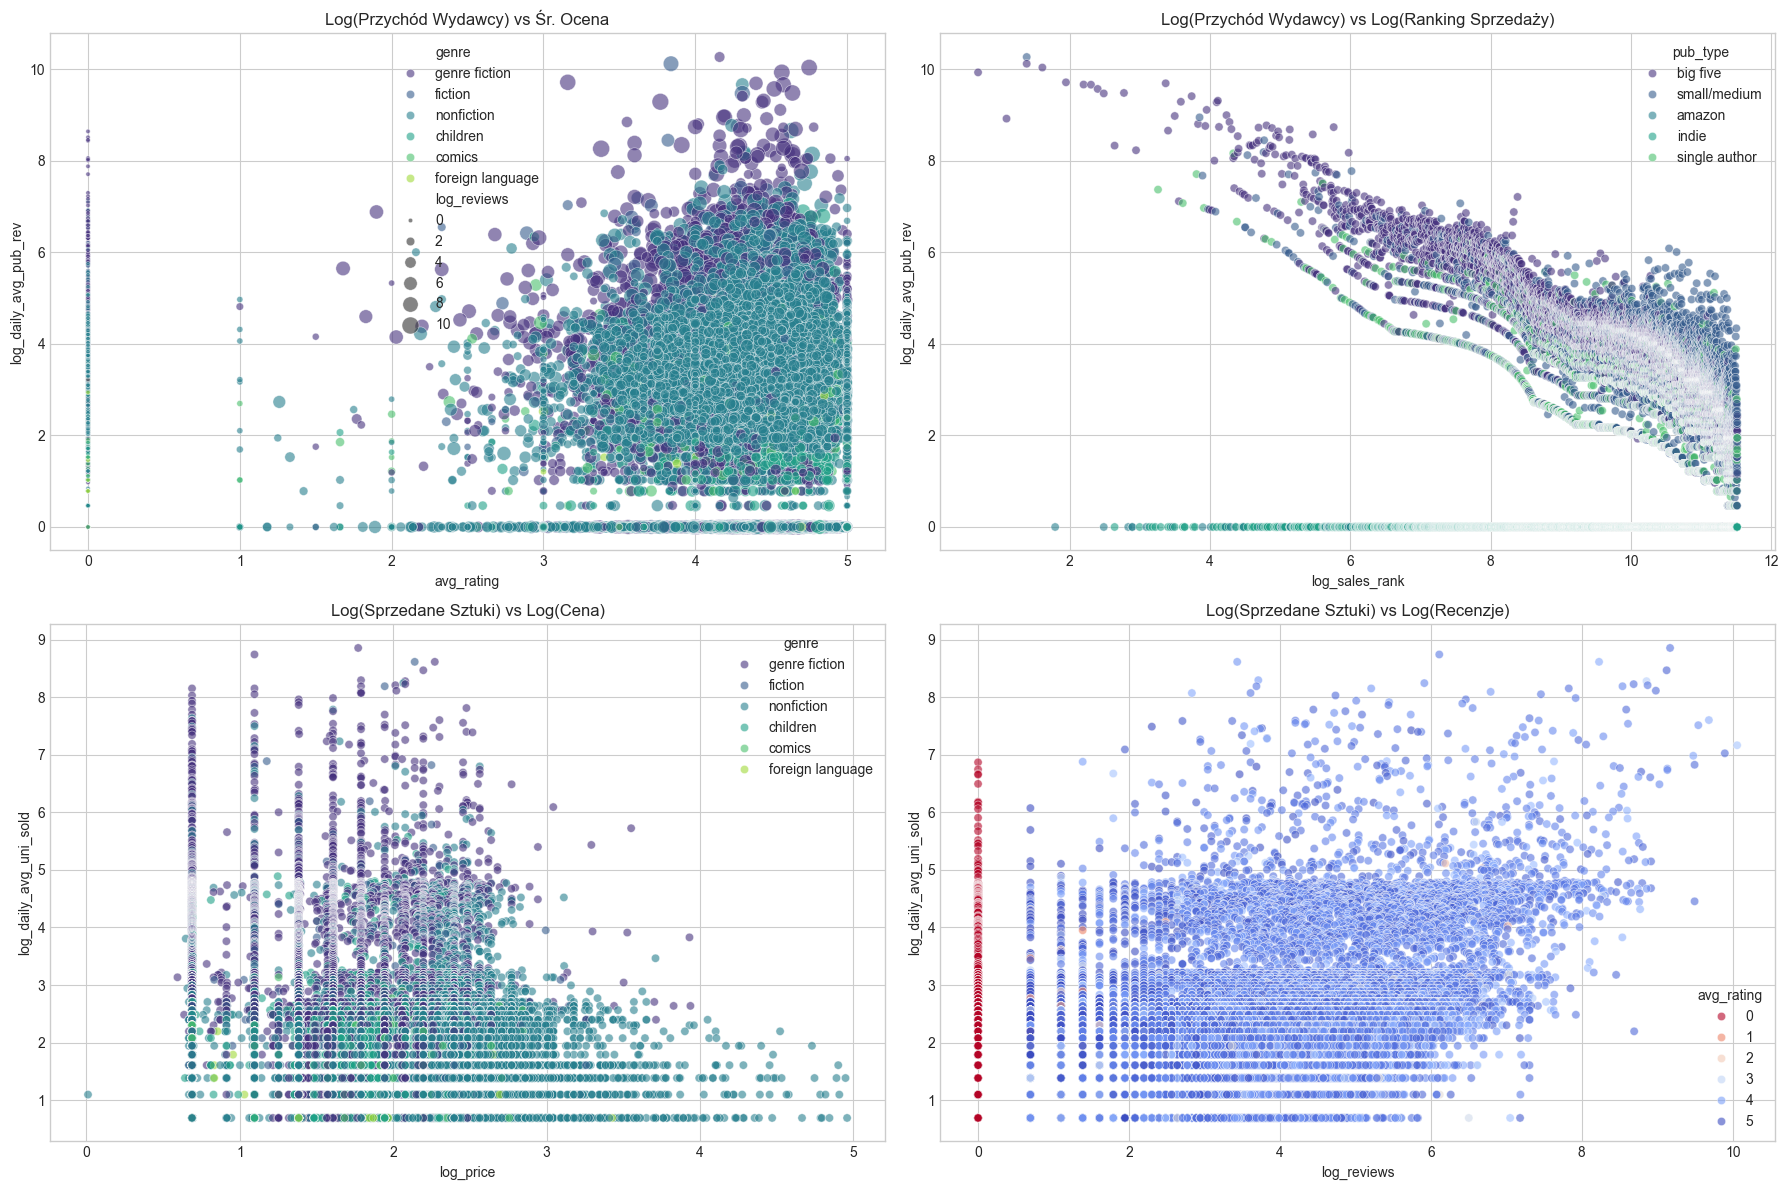

In [70]:
# Komórka 8: Wykresy rozrzutu dla interesujących par zmiennych
plt.figure(figsize=(18, 12)) # Zwiększony rozmiar

plt.subplot(2, 2, 1)
sns.scatterplot(data=df, x='avg_rating', y='log_daily_avg_pub_rev', hue='genre', alpha=0.6, size='log_reviews', sizes=(10,150))
plt.title('Log(Przychód Wydawcy) vs Śr. Ocena')

plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x='log_sales_rank', y='log_daily_avg_pub_rev', hue='pub_type', alpha=0.6)
plt.title('Log(Przychód Wydawcy) vs Log(Ranking Sprzedaży)')
# Pamiętaj: niższy sales_rank jest lepszy, więc oczekujemy trendu "z góry na dół, od lewej do prawej" jeśli jest korelacja

plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='log_price', y='log_daily_avg_uni_sold', hue='genre', alpha=0.6)
plt.title('Log(Sprzedane Sztuki) vs Log(Cena)')

plt.subplot(2, 2, 4)
sns.scatterplot(data=df, x='log_reviews', y='log_daily_avg_uni_sold', hue='avg_rating', palette='coolwarm_r', alpha=0.6)
plt.title('Log(Sprzedane Sztuki) vs Log(Recenzje)')

plt.tight_layout()
plt.show()

C:\Users\Cezar\AppData\Local\Temp\ipykernel_23716\291549975.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='genre', y='log_daily_avg_pub_rev', palette="Spectral", order=order_genre_rev)
C:\Users\Cezar\AppData\Local\Temp\ipykernel_23716\291549975.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='genre', y='avg_rating', palette="Spectral", order=order_genre_rating)


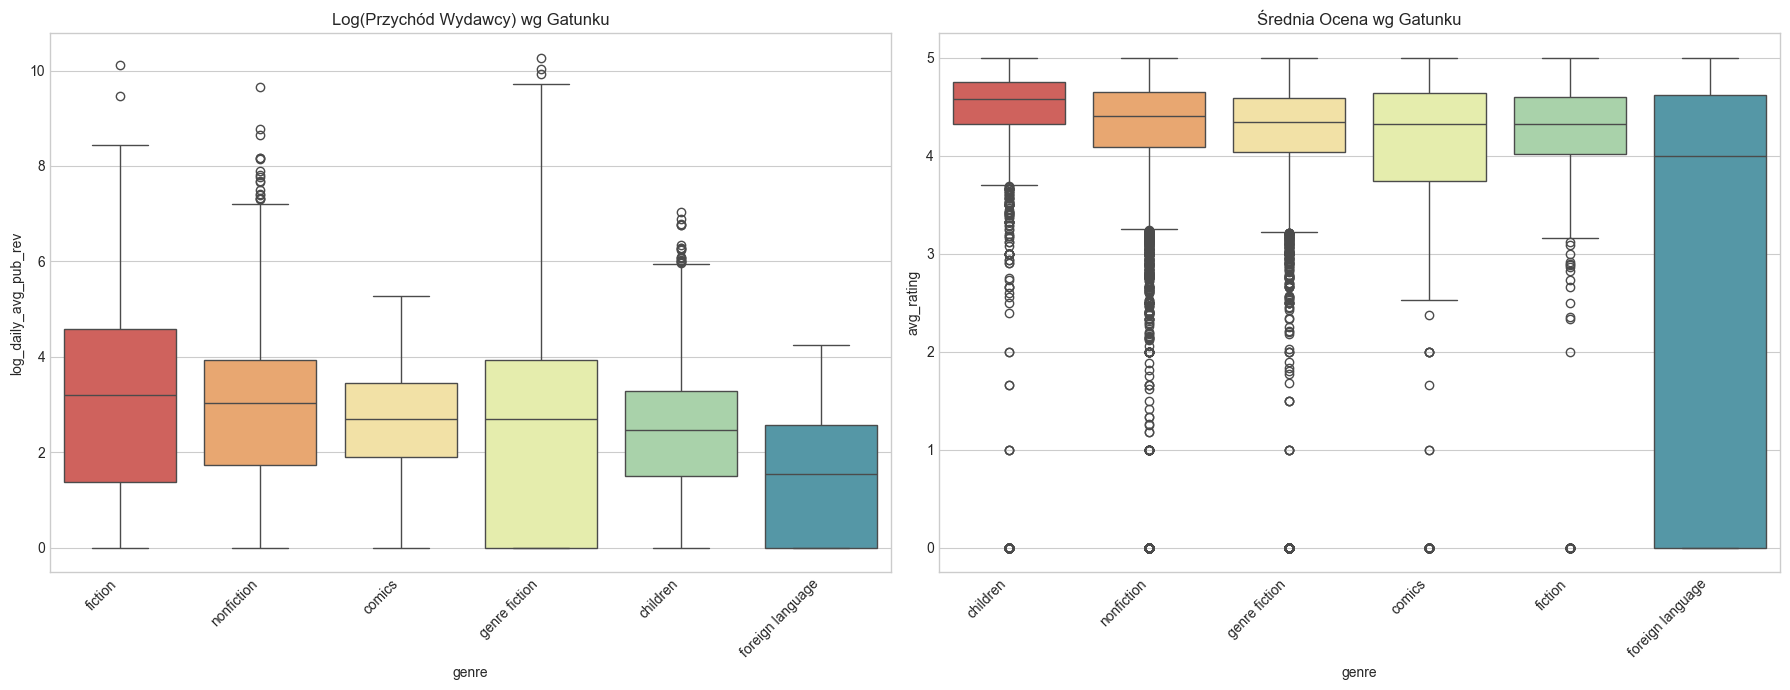

In [71]:
# Komórka 9: Wpływ gatunku (`genre`) na przychody wydawcy i oceny
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
# Sortowanie gatunków wg mediany przychodów dla lepszej czytelności
order_genre_rev = df.groupby('genre')['log_daily_avg_pub_rev'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='genre', y='log_daily_avg_pub_rev', palette="Spectral", order=order_genre_rev)
plt.title('Log(Przychód Wydawcy) wg Gatunku')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
order_genre_rating = df.groupby('genre')['avg_rating'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='genre', y='avg_rating', palette="Spectral", order=order_genre_rating)
plt.title('Średnia Ocena wg Gatunku')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# H5: Czy średnie przychody wydawcy (lub średnie oceny) różnią się istotnie między gatunkami? (Można testować ANOVA)

C:\Users\Cezar\AppData\Local\Temp\ipykernel_23716\3857926818.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='pub_type', y='log_daily_avg_pub_rev', palette="coolwarm", order=order_pub_type_rev)
C:\Users\Cezar\AppData\Local\Temp\ipykernel_23716\3857926818.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='sold_by', y='log_daily_avg_pub_rev', palette="coolwarm", order=order_sold_by_rev)


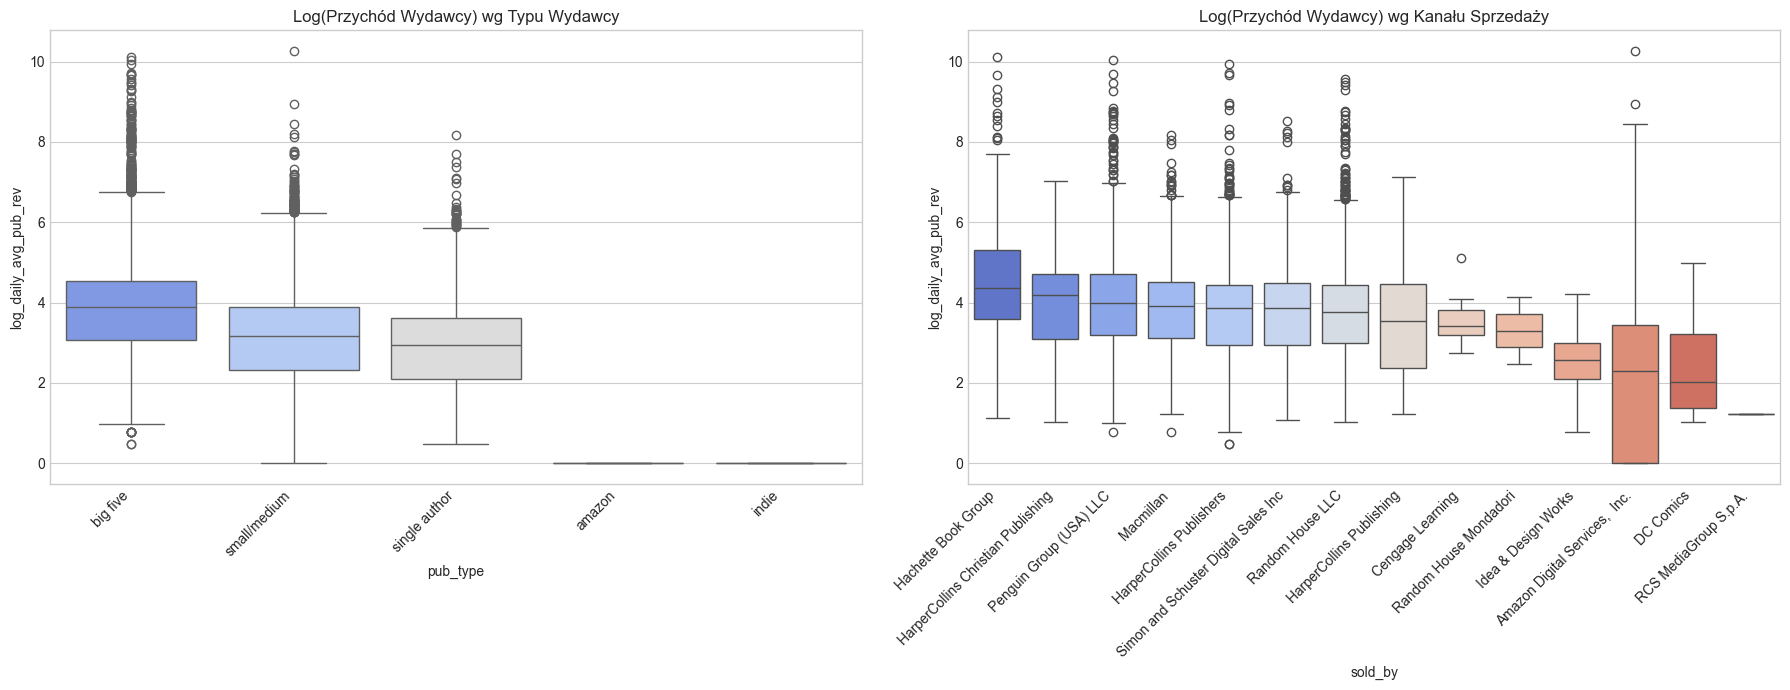

In [72]:
# Komórka 10: Wpływ typu wydawcy (`pub_type`) i kanału sprzedaży (`sold_by`)
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
order_pub_type_rev = df.groupby('pub_type')['log_daily_avg_pub_rev'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='pub_type', y='log_daily_avg_pub_rev', palette="coolwarm", order=order_pub_type_rev)
plt.title('Log(Przychód Wydawcy) wg Typu Wydawcy')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
order_sold_by_rev = df.groupby('sold_by')['log_daily_avg_pub_rev'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='sold_by', y='log_daily_avg_pub_rev', palette="coolwarm", order=order_sold_by_rev)
plt.title('Log(Przychód Wydawcy) wg Kanału Sprzedaży')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# H6: Czy typ wydawcy (np. niezależny vs korporacyjny) ma wpływ na przychody?
# H7: Czy kanał sprzedaży wpływa na przychody wydawcy?

In [73]:
# Komórka 11: Przygotowanie danych do regresji
# Zmienna zależna: log_daily_avg_pub_rev
# Zmienne niezależne: avg_rating, log_price, log_sales_rank, log_reviews,
#                     oraz kategoryczne: genre, pub_type, sold_by (po one-hot encoding)

# Wybierzmy podzbiór df dla modelu, usuwając NaN w kluczowych kolumnach, jeśli jeszcze są
cols_for_model = ['log_daily_avg_pub_rev', 'avg_rating', 'log_price',
                  'log_sales_rank', 'log_reviews', 'genre', 'pub_type', 'sold_by',
                  'daily_avg_uni_sold', 'log_daily_avg_uni_sold'] # dodajmy też sprzedane sztuki
# upewnijmy się, że wszystkie kolumny istnieją, a te które mają być log - są
required_log_cols = ['log_daily_avg_pub_rev', 'log_price', 'log_sales_rank', 'log_reviews', 'log_daily_avg_uni_sold']
actual_cols_for_model = ['avg_rating', 'genre', 'pub_type', 'sold_by'] # Zawsze bierzemy
for lc in required_log_cols:
    if lc in df.columns:
        actual_cols_for_model.append(lc)
    elif lc.replace('log_', '') in df.columns: # Jeśli nie ma log, weź oryginalną (choć niezalecane dla skośnych)
         actual_cols_for_model.append(lc.replace('log_', ''))

# Usuwamy wiersze z NaN w wybranych kolumnach
df_model = df[actual_cols_for_model].copy().dropna()


# Używamy statsmodels z formułą, która automatycznie obsługuje one-hot encoding dla zmiennych kategorycznych
# Upewnijmy się, że nazwa zmiennej zależnej jest poprawna
target_variable = 'log_daily_avg_pub_rev'
if target_variable not in df_model.columns:
    if 'daily_avg_pub_rev' in df_model.columns:
        df_model[target_variable] = np.log1p(df_model['daily_avg_pub_rev'])
        df_model.dropna(subset=[target_variable], inplace=True) # Usuń NaN po logarytmowaniu, jeśli daily_avg_pub_rev było 0
    else:
        print(f"Brak zmiennej '{target_variable}' lub 'daily_avg_pub_rev' w danych do modelu.")
        # Można tu zatrzymać lub wybrać inną zmienną zależną

if target_variable in df_model.columns:
    predictors = [col for col in df_model.columns if col != target_variable]
    
    # Sprawdźmy, czy mamy wystarczająco danych po dropna
    if len(df_model) < (len(predictors) + 50): # Arbitralny próg, np. min 50 obserwacji więcej niż predyktorów
        print(f"Niewystarczająca liczba obserwacji ({len(df_model)}) do zbudowania stabilnego modelu z {len(predictors)} predyktorami. Spróbuj uprościć model.")
    else:
        formula = f"{target_variable} ~ " + " + ".join([f"Q('{col}')" if df_model[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df_model[col]) else col for col in predictors])
        
        # Dla kolumn kategorycznych, statsmodels automatycznie wybierze poziom referencyjny.
        # Można to kontrolować używając C(kolumna, Treatment(referencja))
        # Np. formula = "log_daily_avg_pub_rev ~ avg_rating + log_price + C(genre, Treatment('Fiction')) + ..."

        print(f"\nFormuła regresji: {formula}")

        try:
            model_sm = smf.ols(formula=formula, data=df_model).fit()
            print("\n--- Model Regresji Wielorakiej (statsmodels) ---")
            print(model_sm.summary())

            # H8: Które czynniki (ocena, cena, ranking, recenzje, gatunek, typ wydawcy, kanał sprzedaży)
            # są istotnymi predyktorami przychodów wydawcy?
            # Interpretacja:
            # R-squared: Jaki procent wariancji w log(przychód wydawcy) jest wyjaśniany przez model.
            # P>|t|: Istotność statystyczna poszczególnych predyktorów (niska wartość = istotny).
            # Coef.: Jak zmienia się log(przychód wydawcy) przy jednostkowej zmianie predyktora (ceteris paribus).
            # Dla zmiennych log-log: współczynnik to elastyczność (% zmiana Y dla 1% zmiany X).
            # Dla zmiennych kat.: współczynnik pokazuje różnicę w log(przychód) względem kategorii referencyjnej.

        except Exception as e:
            print(f"Błąd podczas budowy modelu OLS: {e}")
            print("Możliwe przyczyny: perfekcyjna multikolinearność, zbyt mało danych dla niektórych kategorii.")

else:
    print(f"Nie można zbudować modelu, ponieważ brakuje zmiennej zależnej '{target_variable}'.")


Formuła regresji: log_daily_avg_pub_rev ~ avg_rating + Q('genre') + Q('pub_type') + Q('sold_by') + log_price + log_sales_rank + log_reviews + log_daily_avg_uni_sold

--- Model Regresji Wielorakiej (statsmodels) ---
                              OLS Regression Results                             
Dep. Variable:     log_daily_avg_pub_rev   R-squared:                       0.905
Model:                               OLS   Adj. R-squared:                  0.905
Method:                    Least Squares   F-statistic:                     9875.
Date:                   Thu, 29 May 2025   Prob (F-statistic):               0.00
Time:                           21:48:53   Log-Likelihood:                -22634.
No. Observations:                  27027   AIC:                         4.532e+04
Df Residuals:                      27000   BIC:                         4.554e+04
Df Model:                             26                                         
Covariance Type:               nonrobust      


Przykładowe zagregowane dane wydawców:
                      pub_name  avg_log_pub_rev  avg_rating_publisher  \
0            (Indie Publisher)         0.000000              4.157018   
1    (Single-Author Publisher)         2.910785              4.198517   
2  (Small or Medium Publisher)         3.145501              4.175531   
3                      47North         0.000000              3.810390   
4                          Ace         4.478828              3.659800   

   avg_log_price_publisher  total_log_reviews_publisher  \
0                 1.358499                 19214.807378   
1                 1.558477                 11474.123637   
2                 1.997244                 31776.527535   
3                 1.638978                   337.246959   
4                 2.134436                   257.036125   

  primary_genre_publisher  
0              nonfiction  
1              nonfiction  
2              nonfiction  
3           genre fiction  
4           genre fiction 

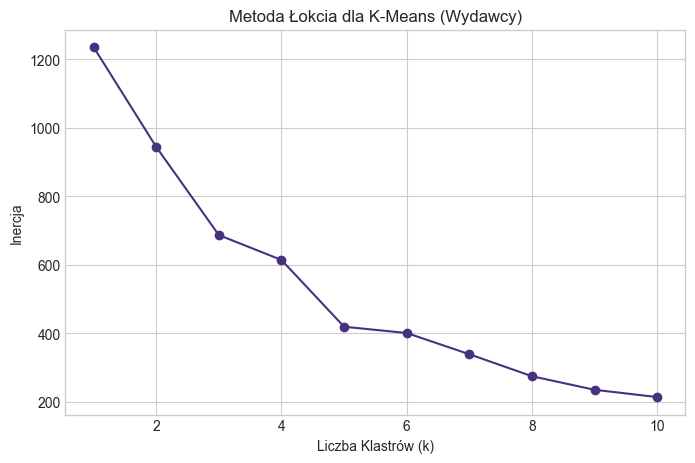


Przypisanie do klastrów (pierwszych 5 wydawców z k=3):
                      pub_name  cluster  avg_log_pub_rev  \
0            (Indie Publisher)        2         0.000000   
1    (Single-Author Publisher)        2         2.910785   
2  (Small or Medium Publisher)        2         3.145501   
3                      47North        0         0.000000   
4                          Ace        1         4.478828   

   avg_rating_publisher  avg_log_price_publisher  total_log_reviews_publisher  
0              4.157018                 1.358499                 19214.807378  
1              4.198517                 1.558477                 11474.123637  
2              4.175531                 1.997244                 31776.527535  
3              3.810390                 1.638978                   337.246959  
4              3.659800                 2.134436                   257.036125  


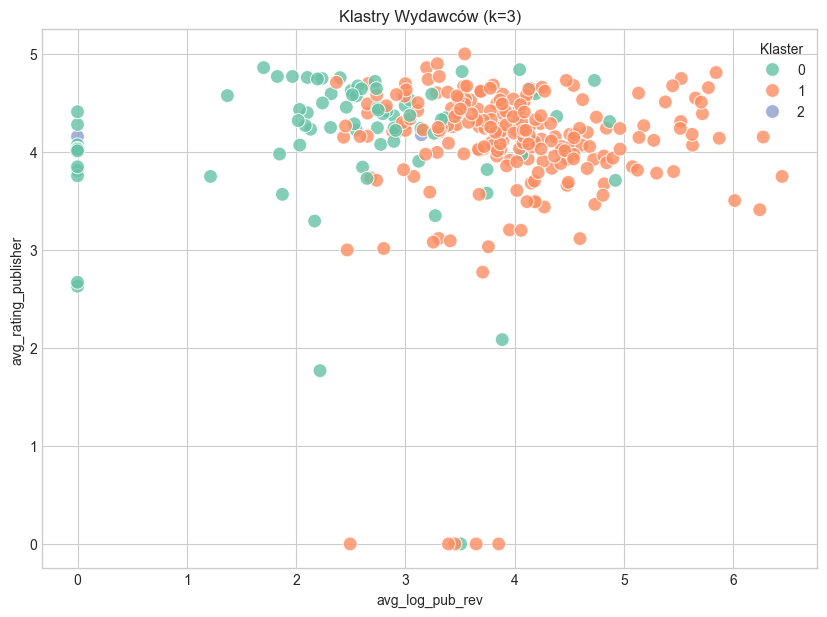

In [74]:
# Komórka 12: Przykład grupowania wydawców (jeśli dane są na poziomie wydawcy lub można je agregować)
# Jeśli dane są na poziomie produktu, możemy grupować produkty.
# Dla przykładu, zagregujmy dane do poziomu wydawcy i spróbujmy K-Means.

if 'pub_name' in df.columns: # Upewnij się, że kolumna istnieje
    # Agregacja (przykładowa - dostosuj metryki i funkcje agregujące)
    # Upewnij się, że wszystkie kolumny do agregacji istnieją
    agg_dict = {}
    if 'log_daily_avg_pub_rev' in df.columns: agg_dict['log_daily_avg_pub_rev'] = 'mean'
    if 'avg_rating' in df.columns: agg_dict['avg_rating'] = 'mean'
    if 'log_price' in df.columns: agg_dict['log_price'] = 'mean'
    if 'log_reviews' in df.columns: agg_dict['log_reviews'] = 'sum' # Suma recenzji dla wydawcy
    if 'genre' in df.columns: agg_dict['genre'] = lambda x: x.mode()[0] if not x.mode().empty else 'Unknown' # Najczęstszy gatunek
    
    if df['pub_name'].nunique() > 5 and agg_dict: # Wymagamy >5 wydawców i zdefiniowanych agregacji
        publisher_agg_df = df.groupby('pub_name').agg(agg_dict).reset_index()
        publisher_agg_df.rename(columns={
            'log_daily_avg_pub_rev': 'avg_log_pub_rev',
            'avg_rating': 'avg_rating_publisher',
            'log_price': 'avg_log_price_publisher',
            'log_reviews': 'total_log_reviews_publisher',
            'genre': 'primary_genre_publisher'
        }, inplace=True)

        print("\nPrzykładowe zagregowane dane wydawców:")
        print(publisher_agg_df.head())

        # Wybierz cechy numeryczne do klastrowania
        features_for_clustering = [col for col in ['avg_log_pub_rev', 'avg_rating_publisher', 'avg_log_price_publisher', 'total_log_reviews_publisher'] if col in publisher_agg_df.columns]
        
        if len(features_for_clustering) >= 2 and not publisher_agg_df[features_for_clustering].isnull().any().any() and len(publisher_agg_df) > 3 : # Min 2 cechy, brak NaN, min 4 wydawców
            X_cluster = publisher_agg_df[features_for_clustering]
            
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_cluster)

            from sklearn.cluster import KMeans
            
            # Znajdź optymalną liczbę klastrów (metoda łokcia)
            inertia = []
            k_range = range(1, min(11, len(publisher_agg_df))) # Max 10 klastrów lub mniej jeśli mało danych
            for k_i in k_range:
                if k_i > 0: # k musi być > 0
                    kmeans = KMeans(n_clusters=k_i, random_state=42, n_init='auto')
                    kmeans.fit(X_scaled)
                    inertia.append(kmeans.inertia_)
            
            if inertia: # Jeśli lista inertia nie jest pusta
                plt.figure(figsize=(8, 5))
                plt.plot(k_range, inertia, marker='o')
                plt.title('Metoda Łokcia dla K-Means (Wydawcy)')
                plt.xlabel('Liczba Klastrów (k)')
                plt.ylabel('Inercja')
                plt.show()

                # Załóżmy, że wybraliśmy k=3 (na podstawie wykresu łokcia)
                chosen_k = 3
                if len(publisher_agg_df) < chosen_k: chosen_k = len(publisher_agg_df) # Nie więcej klastrów niż punktów

                if chosen_k > 0:
                    kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init='auto')
                    publisher_agg_df['cluster'] = kmeans_final.fit_predict(X_scaled)

                    print(f"\nPrzypisanie do klastrów (pierwszych 5 wydawców z k={chosen_k}):")
                    print(publisher_agg_df[['pub_name', 'cluster'] + features_for_clustering].head())

                    # Wizualizacja klastrów (dla 2D)
                    if len(features_for_clustering) >= 2:
                        plt.figure(figsize=(10, 7))
                        sns.scatterplot(data=publisher_agg_df, x=features_for_clustering[0], y=features_for_clustering[1], hue='cluster', palette='Set2', s=100, alpha=0.8)
                        plt.title(f'Klastry Wydawców (k={chosen_k})')
                        plt.xlabel(features_for_clustering[0])
                        plt.ylabel(features_for_clustering[1])
                        plt.legend(title='Klaster')
                        plt.show()
                else:
                    print("Nie można przeprowadzić klastrowania z k=0.")
            else:
                print("Nie udało się wygenerować danych dla metody łokcia.")
        else:
            print("Niewystarczające dane lub cechy do przeprowadzenia klastrowania wydawców.")
    else:
        print("Niewystarczająca liczba unikalnych wydawców lub brak zdefiniowanych agregacji do klastrowania.")
else:
    print("Brak kolumny 'pub_name' do agregacji i klastrowania wydawców.")

In [75]:
# Komórka 13: Podsumowanie (miejsce na Twoje wnioski)
# Tutaj zbierz najważniejsze obserwacje i odpowiedzi na postawione hipotezy.
# Przykłady:
# - "Analiza wykazała, że średnia ocena produktu oraz liczba recenzji są silnie pozytywnie skorelowane z dzienną liczbą sprzedanych sztuk."
# - "Ranking sprzedaży (po transformacji logarytmicznej) wykazuje silną ujemną korelację z przychodami wydawcy, co jest zgodne z oczekiwaniami."
# - "Model regresji (R^2 = X.XX) wskazuje, że cena, liczba recenzji oraz gatunek 'Thriller' (względem gatunku referencyjnego) są istotnymi statystycznie predyktorami przychodów wydawcy."
# - "Wydawcy typu 'Korporacyjny' osiągają średnio wyższe przychody niż 'Niezależni', co może wynikać z większych zasobów marketingowych lub portfolio."
# - "Gatunki X i Y charakteryzują się najwyższymi średnimi przychodami dla wydawców, podczas gdy gatunek Z ma najwyższe średnie oceny."
# - "Analiza klastrów pozwoliła zidentyfikować N grup produktów/wydawców o odmiennych charakterystykach..."
# - "Udział przychodów wydawcy w cenie brutto waha się w zależności od kanału sprzedaży, przy czym kanał 'Direct Publisher' oferuje najwyższy udział."

In [ ]:
# Komórka X: Testy Shapiro-Wilka na normalność rozkładu z informacją o kolumnach logarytmicznych

from scipy import stats
import pandas as pd
import numpy as np

# Zakładamy, że DataFrame 'df' jest już zdefiniowany i wczytany
# oraz, że potencjalnie istnieją kolumny logarytmiczne 
# np. stworzone w poprzednich krokach, jak 'log_price' dla 'price'.

print("Przeprowadzanie testów Shapiro-Wilka z identyfikacją kolumn logarytmicznych...")
print("-----------------------------------------------------------------------------------")
print("Hipoteza Zerowa (H0): Dane w kolumnie pochodzą z rozkładu normalnego.")
print("Hipoteza Alternatywna (H1): Dane w kolumnie nie pochodzą z rozkładu normalnego.")
print("Jeśli p-wartość jest mniejsza od przyjętego poziomu istotności alpha (np. 0.05), odrzucamy H0.")
print("-----------------------------------------------------------------------------------\n")

shapiro_results_list = []
all_column_names_set = set(df.columns) # Używamy set dla szybszego sprawdzania 'in'

# Iteracja po wszystkich kolumnach w DataFrame
for col_name in df.columns:
    w_stat = 'N/A'
    p_val = 'N/A'
    remarks = ''
    column_type_info = 'Oryginalna' # Domyślnie zakładamy, że kolumna jest oryginalna

    # Sprawdzenie, czy kolumna jest logarytmiczna
    if col_name.startswith('log_'):
        base_col_name = col_name[4:] # Nazwa potencjalnej kolumny bazowej (np. 'price' z 'log_price')
        if base_col_name in all_column_names_set:
            column_type_info = f'Logarytmiczna (z: {base_col_name})'
        else:
            # Jeśli nie ma bazowej, ale nazwa sugeruje log, oznaczmy to.
            column_type_info = 'Potencjalnie Logarytmiczna (brak bazowej w df)'
    
    # Sprawdzenie, czy kolumna jest numeryczna
    if pd.api.types.is_numeric_dtype(df[col_name]):
        # Usunięcie wartości NaN, ponieważ test Shapiro-Wilka ich nie obsługuje
        data_to_test = df[col_name].dropna()

        # Test wymaga co najmniej 3 obserwacji
        if len(data_to_test) < 3:
            remarks = f'Zbyt mało danych ({len(data_to_test)} non-NaN) do przeprowadzenia testu.'
        # Test nie działa dla danych stałych (wszystkie wartości takie same)
        elif data_to_test.nunique() < 2:
            remarks = 'Wszystkie wartości w kolumnie (po usunięciu NaN) są identyczne.'
        else:
            try:
                # Przeprowadzenie testu Shapiro-Wilka
                shapiro_test_result = stats.shapiro(data_to_test)
                w_stat = f"{shapiro_test_result.statistic:.4f}"
                p_val = f"{shapiro_test_result.pvalue:.4g}" # Format naukowy dla małych p-wartości

                if len(data_to_test) > 5000:
                    remarks = "N > 5000, p-wartość może być niedokładna. " # Dodajemy spację na końcu
                
                # Interpretacja p-wartości
                alpha = 0.05
                if shapiro_test_result.pvalue < alpha:
                    remarks += f"(p < {alpha}, odrzucamy H0 - dane prawdopodobnie NIE są z rozkładu normalnego)"
                else:
                    remarks += f"(p >= {alpha}, brak podstaw do odrzucenia H0 - dane mogą być z rozkładu normalnego)"

            except Exception as e:
                remarks = f'Błąd podczas testu: {str(e)}'
    else:
        remarks = 'Kolumna nie jest numeryczna.'
        # Jeśli kolumna nie jest numeryczna, to informacja o logarytmie może nie być trafna,
        # chyba że logarytm został źle zidentyfikowany lub jest to nazwa kategoryczna.
        # Na razie pozostawiamy `column_type_info` z poprzedniego kroku, ale dodajemy uwagę o typie.
        if column_type_info.startswith('Logarytmiczna') or column_type_info.startswith('Potencjalnie Logarytmiczna'):
             column_type_info += " (ale nienumeryczna)"
        else:
            column_type_info = 'Nienumeryczna'


    shapiro_results_list.append({
        'Kolumna': col_name,
        'Typ Kolumny': column_type_info, # Dodana informacja o typie kolumny
        'Statystyka W': w_stat,
        'p-wartość': p_val,
        'Uwagi/Interpretacja': remarks
    })

# Konwersja listy wyników do DataFrame dla czytelnego wyświetlenia
shapiro_results_df = pd.DataFrame(shapiro_results_list)

# Wyświetlenie wyników
# Używamy to_string(), aby uniknąć skracania tekstu w kolumnie 'Uwagi/Interpretacja'
print(shapiro_results_df.to_string())

print("\n\n--- Dodatkowe Wyjaśnienia ---")
print("Typ Kolumny:")
print("  - Oryginalna: Kolumna w pierwotnej postaci.")
print("  - Logarytmiczna (z: [nazwa_bazowa]): Kolumna jest transformacją logarytmiczną kolumny [nazwa_bazowa].")
print("  - Potencjalnie Logarytmiczna (brak bazowej w df): Nazwa sugeruje logarytm, ale nie znaleziono odpowiednika bez 'log_'.")
print("  - Nienumeryczna: Kolumna zawiera dane nienumeryczne, test Shapiro-Wilka nie jest stosowany.")
print("\nStatystyka W:")
print("  - Wartości bliskie 1 wskazują, że dane dobrze pasują do rozkładu normalnego.")
print("  - Im mniejsza wartość W, tym większe odchylenie od normalności.")
print("\np-wartość:")
print("  - Mała p-wartość (np. < 0.05) sugeruje, że jest mało prawdopodobne, aby obserwowane dane pochodziły")
print("    z rozkładu normalnego, przy założeniu, że hipoteza zerowa jest prawdziwa.")
print("  - Duża p-wartość (np. >= 0.05) oznacza, że nie mamy wystarczających dowodów, by odrzucić")
print("    hipotezę o normalności rozkładu danych.")
print("\nOgraniczenia testu Shapiro-Wilka:")
print("  - Czułość na rozmiar próby: Dla dużych prób (np. N > kilku tysięcy), test może odrzucić H0")
print("    nawet przy niewielkich, praktycznie nieistotnych odchyleniach od normalności.")
print("    `scipy.stats.shapiro` wyświetla ostrzeżenie dla N > 5000, wskazując, że p-wartość może być niedokładna.")
print("  - Zawsze warto uzupełnić testy statystyczne o inspekcję wizualną (histogramy, wykresy Q-Q).")

Przeprowadzanie testów Shapiro-Wilka z identyfikacją kolumn logarytmicznych...
-----------------------------------------------------------------------------------
Hipoteza Zerowa (H0): Dane w kolumnie pochodzą z rozkładu normalnego.
Hipoteza Alternatywna (H1): Dane w kolumnie nie pochodzą z rozkładu normalnego.
Jeśli p-wartość jest mniejsza od przyjętego poziomu istotności alpha (np. 0.05), odrzucamy H0.
-----------------------------------------------------------------------------------

                      Kolumna                               Typ Kolumny Statystyka W   p-wartość                                                                                                    Uwagi/Interpretacja
0                       genre                             Nienumeryczna          N/A         N/A                                                                                           Kolumna nie jest numeryczna.
1                     sold_by                             Nienumeryczna    

C:\Users\Cezar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27027.
  res = hypotest_fun_out(*samples, **kwds)


In [79]:
print(df.columns)

Index(['genre', 'sold_by', 'daily_rev', 'daily_auth_rev',
       'daily_avg_gross_sales', 'daily_avg_pub_rev', 'daily_avg_uni_sold',
       'pub_name', 'pub_type', 'avg_rating', 'price', 'sales_rank', 'reviews',
       'pub_rev_share', 'auth_rev_share', 'revenue_per_unit',
       'reviews_per_1k_sold', 'log_daily_rev', 'log_daily_auth_rev',
       'log_daily_avg_gross_sales', 'log_daily_avg_pub_rev',
       'log_daily_avg_uni_sold', 'log_price', 'log_sales_rank', 'log_reviews'],
      dtype='object')
